In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATA_IN = '../data/raw/'
DATA_OUT = '../data/clean/'

# Data Import

## Line list

2015-2016 (through June 2016) in stata format

In [3]:
line_list_raw = (pd.read_stata(DATA_IN+'linelist_latin_20160717.dta', convert_dates=True)
                     .drop(['agemonth', 'ageyear'], axis=1)
                     .set_index('id'))

Convert remaining date fields

In [4]:
line_list_date_cols = ['onsetofdisease'] + line_list_raw.columns[line_list_raw.columns.str.contains('date')].tolist()

for col in line_list_date_cols:
    try:
        line_list_raw[col] = pd.to_datetime(line_list_raw[col])
    except ValueError:
        pass

Drop fields with >75% missing values.

In [5]:
line_list_raw = line_list_raw.dropna(axis=1, thresh=int(line_list_raw.shape[0]*0.10))
line_list_raw.shape

(49908, 190)

In [6]:
line_list_raw.head()

,idnumber,dateofbirth,age,gender,u5_gender,addressaimagcity,discrictsoum,khoroobagh,bairgudamj,numberofpersonlivingathome,...,aimag,id_numeric,icd_main,icd_2,icd_3,icd_4,_merge,match_note,died_enhanced,date_onset_2016
id,,,,,,,,,,,,,,,,,,,,,
389.0,UK14290198,1-Sep-2014,210.0,Male,Male,Ulaanbaatar,BZD,13,duureg 3-84,4,...,Ulaanbaatar,14290198,"Contact with hot drinks, food, fats and cookin...",Burns and corrosions of multiple body regions*,Other sepsis*,Missing,3,,0.0,1970-01-01
707.0,UP13220251,2-Feb-2013,790.0,Male,Male,Ulaanbaatar,SKhD,16,25-87 toot,3,...,Ulaanbaatar,13220251,"Pneumonia, organism unspecified*","Pneumonia, organism unspecified*",Missing,Missing,3,,1.0,1970-01-01
1762.0,RI15210414,4-Jan-2015,100.0,Male,Male,Khovsgol,ryenchinlkhumbe,4,gert,4,...,Khvsgl,15210414,"Pneumonia, organism unspecified*",Missing,Missing,Missing,3,,1.0,1970-01-01
2061.0,UK14292376,23-Sep-2014,211.0,Male,Male,Ulaanbaatar,BZD,13,5--26,4,...,East,14292376,Car occupant injured in noncollision transport...,Car occupant injured in noncollision transport...,Missing,Missing,3,,0.0,1970-01-01
6465.0,AZ13321825,18-Dec-2013,510.0,Female,Female,Ulaanbaatar,BZD,22,zau 10-199,3,...,Ulaanbaatar,13321825,Other congenital malformations of heart*,Missing,Missing,Missing,3,,1.0,1970-01-01


In [7]:
line_list_raw.dtypes.value_counts()

object            129
float32            25
datetime64[ns]     19
float64             6
category            2
int8                2
category            1
category            1
category            1
category            1
category            1
category            1
category            1
dtype: int64

In [8]:
cols_to_keep = ['date_onset', 'provincecity', 'sex', 'dob_final', 'age_years', 'died_enhanced', 
                'confirmed', 'labconfirmed', 'date_lab', 'vaccine_ever']

line_list = line_list_raw[cols_to_keep]

In [9]:
line_list.head()

,date_onset,provincecity,sex,dob_final,age_years,died_enhanced,confirmed,labconfirmed,date_lab,vaccine_ever
id,,,,,,,,,,
389.0,2015-03-30,UB,Male,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0
707.0,2015-04-03,UB,Male,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0
1762.0,2015-04-14,KhU,Male,2015-01-04,0.279261,1.0,1.0,0.0,NaT,0.0
2061.0,2015-04-22,UB,Male,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0
6465.0,2015-05-12,UB,Female,2013-12-18,1.314168,1.0,0.0,0.0,NaT,0.0


Additional line list data (July to December 2016)

In [10]:
line_list_2016_raw = pd.read_csv(DATA_IN + 'MNG2016 (July to Dec).csv', index_col=0, parse_dates=True)
line_list_2016_raw.columns = ['_'.join(x) for x in line_list_2016_raw.columns.str.lower().str.replace('\r','').str.split(' ').values]

In [11]:
for date_field in ('donset', 'dob', 'dscoll', 'dlabrec'):
    line_list_2016_raw[date_field] = pd.to_datetime(line_list_2016_raw[date_field])

In [13]:
cols_to_keep_2016 = ['donset', 'infection_province', 'sex', 'dob', 'age', 'outcome',  
                'mclass', 'mconfmeth', 'dlastvac', 'dlabrec']
line_list_2016 = line_list_2016_raw[cols_to_keep_2016].copy()

Recode variables to match main dataset

In [13]:
province_lookup = {'AR':'Arkhangai',
    'Bay':'Bayan Ulgii',
    'BKh':'Bayankhongor',
    'BU':'Bulgan',
    'DA':'Darkhan-Uul',
    'DG':'Dornogobi',
    'DO':'Dornod',
    'DU':'Dundgovi',
    'GA':'Gobi altai',
    'GS':'Govisumber',
    'KhE':'Khentii',
    'KhO':'Khovd',
    'KhU':'Khuvsgul',
    'OR':'Orkhon',
    'SB':'Sukhbaatar',
    'SE':'Selenge',
    'TU':'Tuv',
    'UB':'Ulaanbaatar',
    'UG':'Umnogovi',
    'UV':'Uvurkhangai',
    'UVs':'Uvs',
    'ZA':'Zavkhan'}

inverse_province_lookup = res = dict((v,k) for k,v in province_lookup.items())

In [14]:
line_list_2016 = (line_list_2016.assign(provincecity=line_list_2016.infection_province.replace(inverse_province_lookup),
                                       confirmed=(line_list_2016.mclass==1).astype(int),
                                       labconfirmed=((line_list_2016.mclass==1) 
                                                     & (line_list_2016.mconfmeth==1)).astype(int),
                                       male=(line_list_2016.sex=='Male').astype(int),
                                       died=(line_list_2016.outcome==2).astype(int),
                                       vaccine_ever=line_list_2016.dlastvac.notnull().astype(int))
                        .drop(['outcome', 'mconfmeth', 'mclass', 'sex', 'infection_province', 'dlastvac'], axis=1)
                        .rename(columns={'age':'age_years', 
                                         'donset':'date_onset',
                                        'dlabrec':'date_lab'})
                 )

In [15]:
line_list_2016.shape

(442, 10)

In [16]:
line_list = (line_list.assign(male=line_list.sex=='Male')
                    .drop(['sex'], axis=1)
                    .rename(columns={'dob_final':'dob',
                                    'died_enhanced':'died'})
            )

In [17]:
line_list.shape

(49908, 10)

In [18]:
line_list_merged = pd.concat([line_list, line_list_2016], ignore_index=True)

In [19]:
line_list_merged.head()

,age_years,confirmed,date_lab,date_onset,died,dob,labconfirmed,male,provincecity,vaccine_ever
0,0.577686,1.0,2015-04-06,2015-03-30,0.0,2014-09-01,1.0,1,UB,0.0
1,2.162902,1.0,2015-04-04,2015-04-03,1.0,2013-02-02,1.0,1,UB,0.0
2,0.279261,1.0,NaT,2015-04-14,1.0,2015-01-04,0.0,1,KhU,0.0
3,0.577686,1.0,2015-04-24,2015-04-22,0.0,2014-09-23,1.0,1,UB,0.0
4,1.314168,0.0,NaT,2015-05-12,1.0,2013-12-18,0.0,0,UB,0.0


In [20]:
line_list_merged.shape

(50350, 10)

In [21]:
line_list['month_onset'] = line_list.date_onset.dt.month
line_list['year_onset'] = line_list.date_onset.dt.year

Monthly distribution of all cases

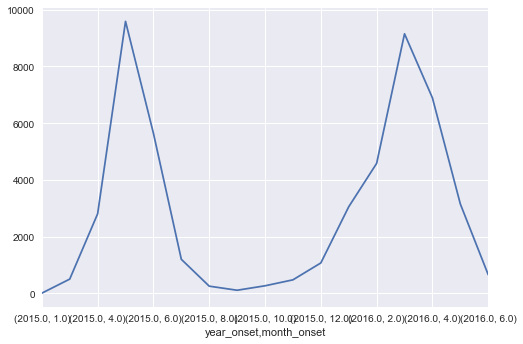

In [22]:
line_list.groupby(['year_onset', 'month_onset']).date_onset.count().plot()

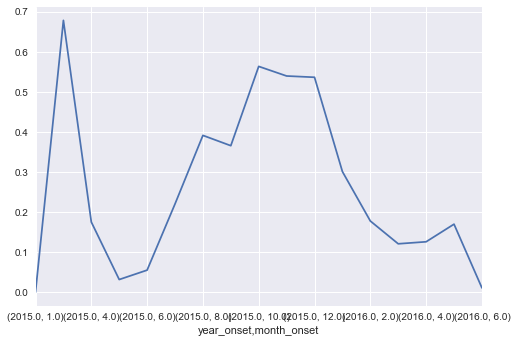

In [23]:
line_list.groupby(['year_onset', 'month_onset']).date_lab.apply(lambda x: x.notnull().mean()).plot()

Monthly distribution of lab-confirmed only

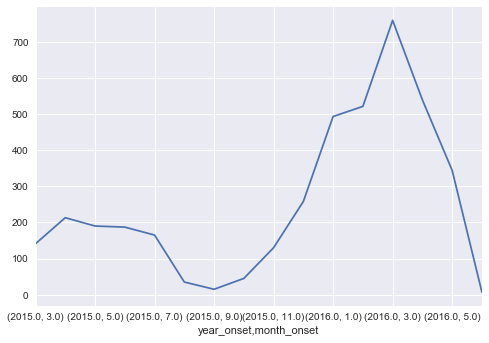

In [24]:
line_list[line_list.labconfirmed==1].groupby(['year_onset', 'month_onset']).date_onset.count().plot()

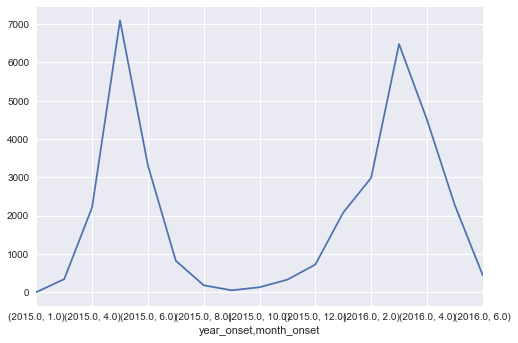

In [25]:
line_list[line_list.confirmed==1].groupby(['year_onset', 'month_onset']).date_onset.count().plot()

Export merged data

In [28]:
line_list.to_csv(DATA_OUT+'line_list.csv')

## Birth cohort

Routine and SIA vaccination coverage, birth cohort population size, and total suspected cases in each year since 1925

MCV is coverage proportion

In [26]:
birth_cohort_raw = pd.read_csv(DATA_IN+'birth cohort.csv')
birth_cohort_raw.tail()

,Age,Birth cohort,Measles.cases,MCV1,MCV2,SIA 1994 (M),SIA 1996 (M),SIA 2000 (M),SIA 2007 (M),SIA 2012 (MR),Target,Coverage.survey,serosurvey 2004,sero1996,sero9799,Population,Total cases
86,4,2011,53.0,0.98,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
87,3,2012,71.0,0.99,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
88,2,2013,158.0,0.99,0.99,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
89,1,2014,682.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,67706.8,0.0
90,0,2015,294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67706.8,18188.0


## Supplemental immunization

Details of coverage of outbreak response campaigns in 2015 and 2016, by age group and Aimag

In [29]:
sia_2015 = pd.read_excel(DATA_IN+'MR SIA 2015.xlsx', skiprows=49, index_col=0).dropna(axis=1)
sia_2015

,0,1,2,3,4,5
Arkhangai,860,1840,1843,1873,1808,1837
Bayan-Ulgii,1361,2203,2447,2233,2186,1872
Bayankhongor,928,1631,1797,1854,1710,2019
Bulgan,574,1084,1195,1139,1076,1430
Gobi-Altai,494,989,1132,1183,1186,1276
Gobisumber,210,404,376,362,357,391
Darkhan-uul,1205,2162,2081,2094,2071,2115
Dornogobi,780,1391,1483,1455,1419,1496
Dornod,555,797,1147,1335,1344,1953
Dundgobi,400,782,811,835,853,1127


In [30]:
sia_2016 = pd.read_excel(DATA_IN+'MR SIA 2016.xlsx', skiprows=2, index_col=0).drop('TOTAL').dropna()

In [31]:
sia_2016.index.name = 'age'

In [32]:
sia_2016.index = pd.Series(sia_2016.index.str.split(' ')).apply(lambda x: int(x[0]))

In [33]:
sia_2016.tail()

,AR,Bay,BKh,BU,GA,GS,DA,DG,DO,DU,...,UG,SB,SE,TU,Uvs,KhO,KhU,KhE,UB,TOTAL
age,,,,,,,,,,,,,,,,,,,,,
26,1125.0,1338.0,1292.0,765.0,727.0,310.0,1379.0,1161.0,1057.0,562.0,...,1016.0,913.0,1855.0,1461.0,937.0,1131.0,1684.0,958.0,25282.0,48428.0
27,1140.0,1263.0,1276.0,741.0,732.0,325.0,1264.0,1168.0,983.0,571.0,...,1112.0,889.0,1878.0,1363.0,926.0,1092.0,1694.0,920.0,24421.0,47394.0
28,1069.0,1240.0,1204.0,735.0,721.0,290.0,1364.0,1084.0,1001.0,530.0,...,1057.0,868.0,1706.0,1376.0,871.0,1056.0,1664.0,960.0,23952.0,46230.0
29,1067.0,1156.0,1195.0,728.0,685.0,266.0,1232.0,1093.0,952.0,557.0,...,1053.0,860.0,1713.0,1294.0,848.0,971.0,1577.0,930.0,21818.0,43462.0
30,1332.0,1290.0,1425.0,772.0,797.0,419.0,1444.0,1073.0,1066.0,608.0,...,1081.0,1138.0,1903.0,1612.0,916.0,1239.0,2022.0,1017.0,28994.0,54439.0


In [34]:
sia_2016.shape

(13, 23)

## Population

Population by age group in each province

In [35]:
population = pd.read_csv(DATA_IN+'denominators.csv', index_col=0)
population.head()

,Total,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
Province,,,,,,,,,,,,,,,,
Arkhangai,92896,10440,8360,7883,9249,9469,8207,6856,6824,6294,5498,4643,3266,2202,1237,2468
Bayan-Ulgii,93165,11655,10219,9929,8794,8872,8531,7207,6199,5713,4633,3842,2747,1665,1006,2153
Bayankhongor,79310,9760,7429,6675,7812,7992,7436,6280,5806,5165,4383,3714,2436,1480,1008,1934
Bulgan,60324,6415,5351,4556,5423,5587,4977,4499,4592,4426,4066,3494,2619,1666,877,1776
Gobi-Altai,56698,5953,5392,5046,5778,5631,4837,4401,4345,3994,3389,2730,1974,1064,706,1458
